In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Dataset Loading and EDA

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test labels: {dict(zip(unique, counts))}")

Train labels: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


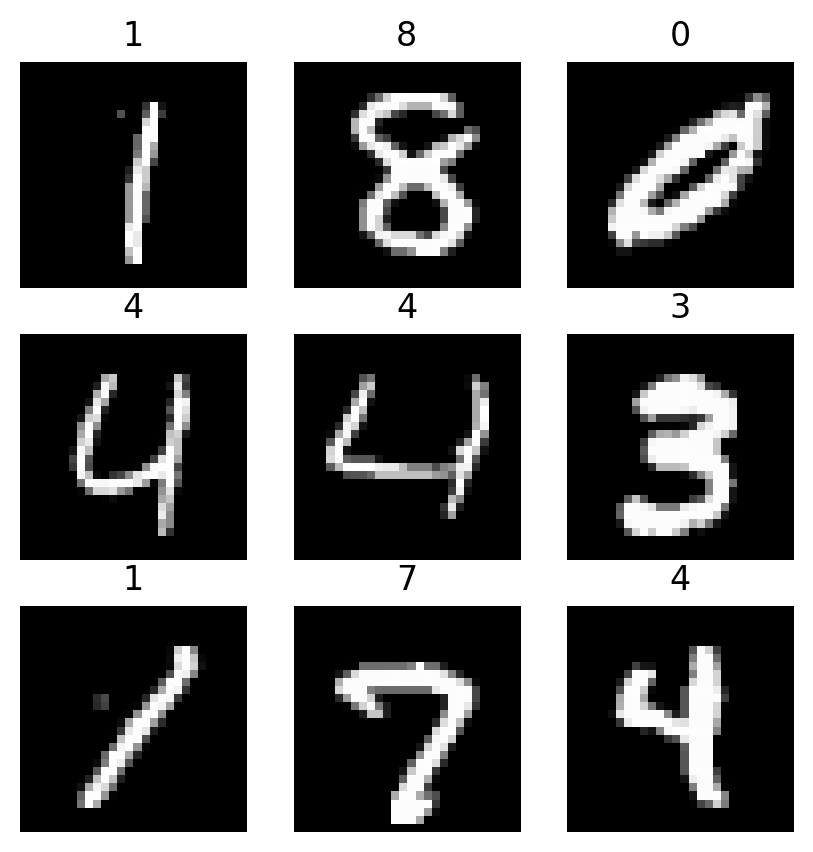

In [5]:
indexes = np.random.randint(0, x_train.shape[0], size=9)

plt.figure(figsize=(5,5))
for idx, i in enumerate(indexes):
    plt.subplot(3,3,idx+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
    plt.title(y_train[i])
plt.show()

## Preprocessing

In [6]:
from keras.layers import Dense, Activation, SimpleRNN

In [7]:
num_labels = len(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size])
x_test = np.reshape(x_test, [-1, image_size, image_size])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

input_shape = (image_size, image_size) #실제로 (timesteps, input_dim)
batch_size = 128
units = 256 #출력 유닛의 개수
dropout = 0.2
### RNN의 출력은 현재 입력 + 이전 출력 혹은 은닉 상태로 구성

## Modeling

In [9]:
def create_func_model():
    inputs = keras.Input(shape=input_shape)
    rnn1 = SimpleRNN(units=units,
                     dropout=dropout
                    )(inputs)
    outputs = Dense(num_labels,
                   activation='softmax'
                  )(rnn1)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
func_model = create_func_model()
func_model.summary()

2023-06-20 14:24:42.232977: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-20 14:24:42.233002: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-06-20 14:24:42.233017: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-06-20 14:24:42.233432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-20 14:24:42.233785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               72960     
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 75530 (295.04 KB)
Trainable params: 75530 (295.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


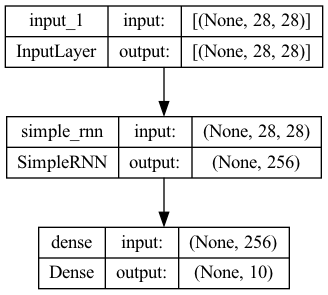

In [12]:
keras.utils.plot_model(model=func_model,
                       to_file='MNIST_RNN.png',
                       show_shapes=True
                      )

In [15]:
learning_rate = 0.001
func_model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.legacy.SGD(learning_rate=learning_rate),
                   metrics=['accuracy']
                  )

In [17]:
history = func_model.fit(x_train, y_train,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=(x_test, y_test)
                        )

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.5980

2023-06-20 14:27:19.725293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 86s 184ms/step - loss: 1.3792 - accuracy: 0.5980 - val_loss: 1.0548 - val_accuracy: 0.7141
Epoch 2/10
469/469 [==============================] - 87s 185ms/step - loss: 1.0051 - accuracy: 0.7163 - val_loss: 0.8162 - val_accuracy: 0.7784
Epoch 3/10
469/469 [==============================] - 88s 188ms/step - loss: 0.8356 - accuracy: 0.7615 - val_loss: 0.6916 - val_accuracy: 0.8122
Epoch 4/10
469/469 [==============================] - 86s 183ms/step - loss: 0.7322 - accuracy: 0.7913 - val_loss: 0.6048 - val_accuracy: 0.8366
Epoch 5/10
469/469 [==============================] - 86s 183ms/step - loss: 0.6563 - accuracy: 0.8129 - val_loss: 0.5334 - val_accuracy: 0.8592
Epoch 6/10
469/469 [==============================] - 90s 192ms/step - loss: 0.5901 - accuracy: 0.8323 - val_loss: 0.4761 - val_accuracy: 0.8750
Epoch 7/10
469/469 [==============================] - 95s 202ms/step - loss: 0.5366 - accuracy: 0.8470 - val_loss: 0.4257 - val_accuracy: 0.8

In [18]:
loss, acc = func_model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"Test accuracy: {(100*acc):>.1f}%")

79/79 [==============================] - 3s 35ms/step - loss: 0.3231 - accuracy: 0.9114
Test accuracy: 91.1%


## Visualization

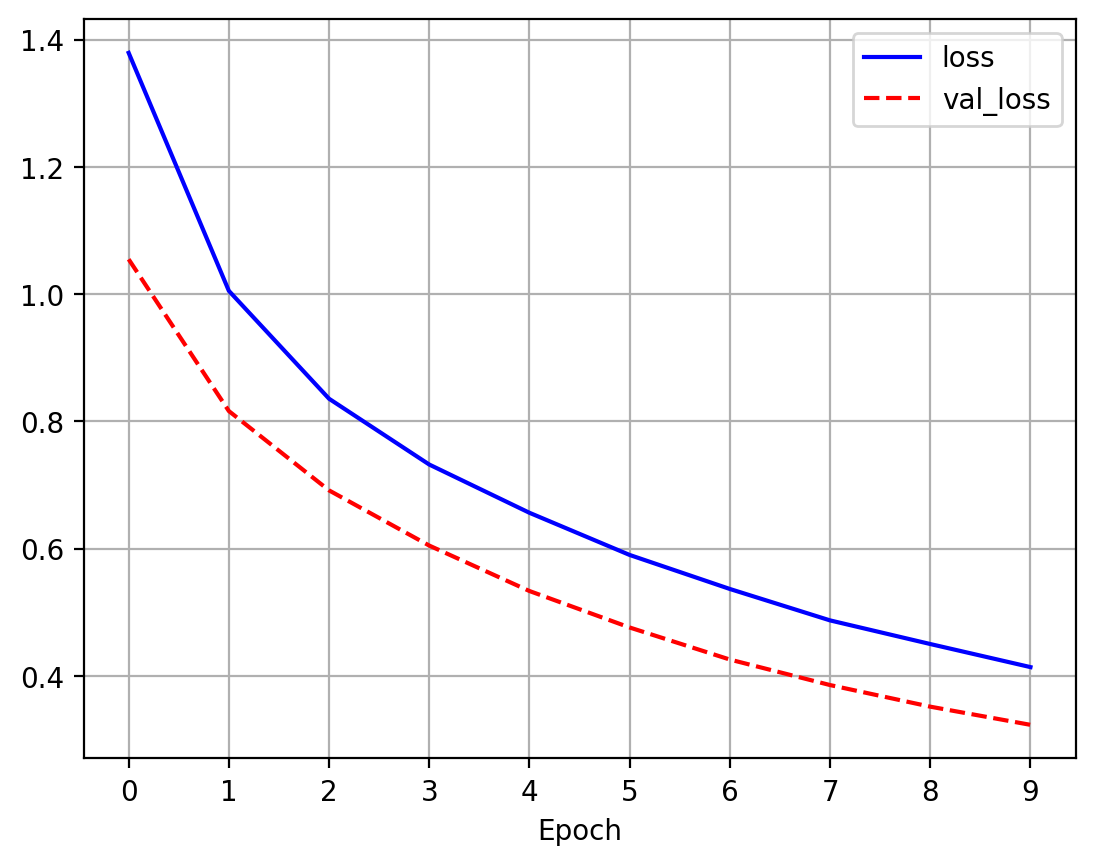

In [19]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.xticks(range(10))
plt.grid()
plt.legend()
plt.show()

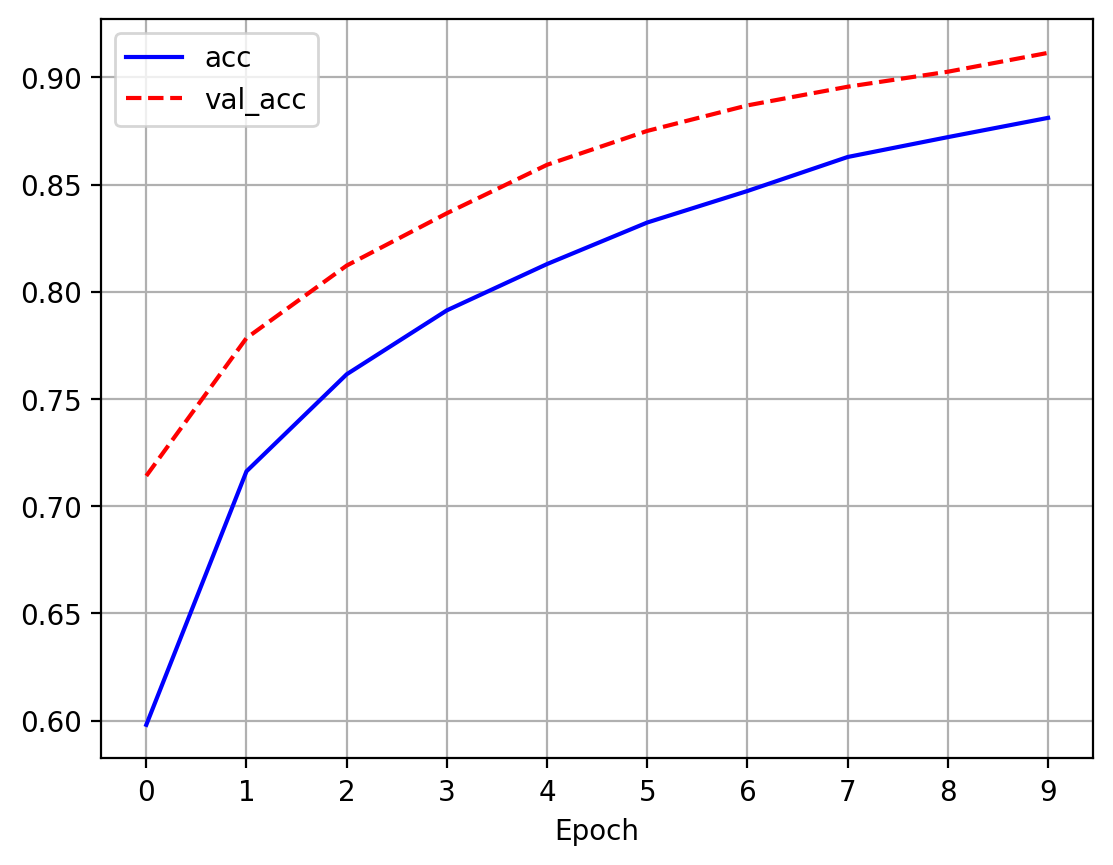

In [20]:
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.xticks(range(10))
plt.grid()
plt.legend()
plt.show()

## Save and Load

In [21]:
func_model.save('./save/func_model')

INFO:tensorflow:Assets written to: ./save/func_model/assets


INFO:tensorflow:Assets written to: ./save/func_model/assets


In [22]:
func_model.save_weights('./save/func_model.skpt')

In [23]:
func_model_2 = keras.models.load_model('./save/func_model')

In [24]:
func_model_2.evaluate(x_test, y_test)

  3/313 [..............................] - ETA: 10s - loss: 0.2747 - accuracy: 0.8958

2023-06-20 14:40:58.585832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 11s 35ms/step - loss: 0.3231 - accuracy: 0.9114


[0.3230985999107361, 0.9114000201225281]